## Problema 5: Rutas optimas para equipos de inspeccion de infraestructura en Colombia

### Preprocesamiento de datos

In [17]:
import numpy as np
import csv

def read_cost_matrix_csv(filename):
    """
    Lee una matriz de costos desde un archivo CSV y la devuelve como un array de numpy.
    Se asume que la primera fila contiene los IDs de las localidades.

    Parámetros:
        filename (str): Nombre del archivo CSV de entrada.

    Devuelve:
        numpy.ndarray: La matriz de costos leída desde el archivo.
    """
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        node_ids = next(reader)  # Lee los IDs de las localidades (no usado en este caso)
        data = list(reader)  # Lee los datos restantes

    # Convierte los datos a un array de numpy de enteros
    cost_matrix = np.array(data, dtype=int)

    return cost_matrix

def validate_cost_matrix(cost_matrix):
    """Verifica que la matriz de costos no tenga valores negativos o NaN."""
    if np.any(cost_matrix < 0):
        print("Error: La matriz de costos contiene valores negativos.")
        return False
    if np.any(np.isnan(cost_matrix)):
        print("Error: La matriz de costos contiene valores NaN.")
        return False
    return True

# Leer y validar la matriz de costos
filename = './matrix_cost/cost_matrix_10_nodes_1.5_spread.csv'  # Ajusta el nombre del archivo según tu caso
cost_matrix = read_cost_matrix_csv(filename)

# Verificar la validez de la matriz
if validate_cost_matrix(cost_matrix):
    print("La matriz de costos es válida.")
else:
    print("La matriz de costos no es válida.")

La matriz de costos es válida.


### Formulacion para un unico viajero

#### Conjuntos

Nodos: 
$$ N = \{N1,N_2,...,N_n\}$$
$$ \forall i \in N$$
$$ \forall j \in N$$

#### Parametros

Costos: De ir de i a j
$$ c_{ij}: \forall i\in N, \forall j\in N$$

#### Variables de decision

Tomar el camino de i a j
$$ x_{ij} \in {0,1}$$

Auxiliar para subtours
$$ u_{i} \leq n-1$$


#### Funcion objetivo

$$ MIN(\sum_{i\in N} \sum_{j\in N} x_{ij} \cdot c_{ij})$$

Costo total del viaje (se minimiza)

#### Restricciones

Cada localidad tiene una entrada

$$ \sum_{i\in D, i \neq j} x_{ij} = 1  , \forall j \in N$$

Cada localidad tiene una salida

$$ \sum_{j\in O, i \neq j} x_{ij} = 1 , \forall i \in N$$

No tener autociclos

$$ x_{i,i} = 0, \forall i \in N $$

$$ u_{i} \geq 0$$

Subtours

$$ u_i - u_j + n \cdot x_{ij} \leq n - 1, \forall i, j / i \neq j, i \neq 1, j \neq 1 \in N $$



In [18]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt

class Optimization:
    def __init__(self, cost_matrix):
        self.cost_matrix = cost_matrix
        self.num_cities = len(cost_matrix)

    def build_model(self):
        # Crear el modelo
        self.model = pyo.ConcreteModel()

        # Conjuntos
        self.model.N = pyo.RangeSet(1, self.num_cities)

        # Variables de decisión: x[i, j] = 1 si viaja de i a j
        self.model.x = pyo.Var(self.model.N, self.model.N, within=pyo.Binary)

        # Variable auxiliar u[i] para eliminar subtours
        self.model.u = pyo.Var(self.model.N, within=pyo.NonNegativeIntegers, bounds=(1, self.num_cities - 1))

        # Parámetro de costos c[i, j]
        def cost_init(model, i, j):
            return self.cost_matrix[i - 1][j - 1]
        self.model.c = pyo.Param(self.model.N, self.model.N, initialize=cost_init)

        # Función objetivo: Minimizar el costo total
        def objective_function(model):
            return sum(model.x[i, j] * model.c[i, j]
                       for i in model.N for j in model.N)
        self.model.objective = pyo.Objective(rule=objective_function, sense=pyo.minimize)

        # Restricciones: cada ciudad tiene exactamente una salida
        def outbound_rule(model, i):
            return sum(model.x[i, j] for j in model.N if j != i) == 1
        self.model.outbound = pyo.Constraint(self.model.N, rule=outbound_rule)

        # Restricciones: cada ciudad tiene exactamente una entrada
        def inbound_rule(model, j):
            return sum(model.x[i, j] for i in model.N if i != j) == 1
        self.model.inbound = pyo.Constraint(self.model.N, rule=inbound_rule)

        # Restricción de no auto-ciclos
        def no_self_loops(model, i):
            return model.x[i, i] == 0
        self.model.no_self_loops = pyo.Constraint(self.model.N, rule=no_self_loops)

        # Restricciones de eliminación de subtours
        def subtour_elimination(model, i, j):
            if i != j and i != 1 and j != 1:
                return model.u[i] - model.u[j] + self.num_cities * model.x[i, j] <= self.num_cities - 1
            else:
                return pyo.Constraint.Skip
        self.model.subtour_elimination = pyo.Constraint(self.model.N, self.model.N, rule=subtour_elimination)


    def print_output(self):
        """
        Plots the solution as a directed graph using NetworkX and matplotlib.
        Since there's only one route (single driver), all edges are colored the same.
        """
        valid_edges = []
        for i in self.model.N:
            for j in self.model.N:
                if pyo.value(self.model.x[i, j]) > 0.5:
                    valid_edges.append((i, j))

        # Build a directed graph
        G = nx.DiGraph()
        G.add_nodes_from(self.model.N)

        # Add edges from the solution
        for (i, j) in valid_edges:
            G.add_edge(i, j)

        pos = nx.spring_layout(G)
        nx.draw_networkx(G, pos, with_labels=True,
                         node_color='lightblue',
                         edge_color='red',
                         arrows=True)
        plt.axis("off")
        plt.show()



In [19]:
# Crear el modelo
tsp = Optimization(cost_matrix)
tsp.build_model()


In [20]:
solver = pyo.SolverFactory('glpk')
r = solver.solve(tsp.model)


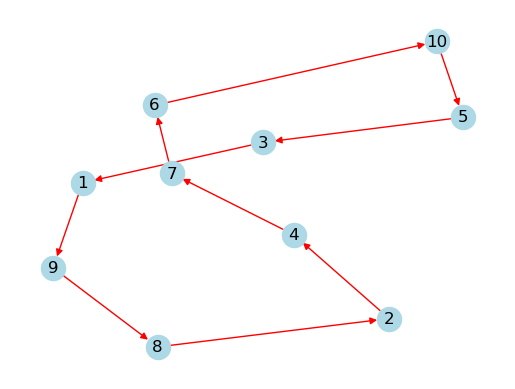

In [21]:
tsp.print_output()


### Extension a multiples viajeros

#### Conjuntos

Nodos: 
$$ N = \{N1,N_2,...,N_n\}$$
$$ \forall i \in N$$
$$ \forall j \in N$$

#### Parametros

Costos: De ir de i a j
$$ c_{ij}: \forall i\in N, \forall j\in N$$

Numero de viajeros
$$ K $$

#### Variables de decision

Viajero k toma el camino de i a j
$$ x_{ijk} \in {0,1}$$

Auxiliar para subtours
$$ u_{i} \leq n-1$$


#### Funcion objetivo

$$ MIN(\sum_{i\in N} \sum_{j\in N} \sum_{k\in K} x_{ijk} \cdot c_{ij})$$

Costo total del viaje (se minimiza)

#### Restricciones

Cada localidad tiene una entrada

$$ \sum_{i\in D, i \neq j} \sum_{k\in K} x_{ijk} = 1  , \forall j \in N$$

Cada localidad tiene una salida

$$ \sum_{j\in O, i \neq j} \sum_{k\in K} x_{ijk} = 1 , \forall i \in N$$

No tener autociclos

$$ x_{i,i,k} = 0, \forall i \in N \forall k \in K $$

$$ u_{i} \geq 0$$

Subtours

$$ u_i - u_j + n \cdot x_{ijk} \leq n - 1, \forall i, j, k / i \neq j, i \neq 1, j \neq 1 \in N $$

Unicidad de localidad por equipo

$$ \sum_{K\in K} x_{ijk} = 1 , \forall j,i \in N / i \neq j$$



In [22]:
class Optimization2:
    def __init__(self, cost_matrix, num_teams):
        self.cost_matrix = cost_matrix
        self.num_cities = len(cost_matrix)  # Inferir número de ciudades desde la matriz
        self.num_teams = num_teams  # Número de equipos

    def build_model(self):
        # Crear el modelo
        self.model = pyo.ConcreteModel()

        # Conjuntos
        self.model.N = pyo.RangeSet(1, self.num_cities)
        self.model.K = pyo.RangeSet(1, self.num_teams)  # Conjunto de equipos

        # Variables de decisión: x[i, j, k] = 1 si el equipo k viaja de i a j
        self.model.x = pyo.Var(self.model.N, self.model.N, self.model.K, within=pyo.Binary)

        # Variable auxiliar u[i] para eliminar subtours
        self.model.u = pyo.Var(self.model.N, within=pyo.NonNegativeIntegers, bounds=(1, self.num_cities - 1))

        # Parámetro de costos c[i, j]
        def cost_init(model, i, j):
            return self.cost_matrix[i - 1][j - 1]
        self.model.c = pyo.Param(self.model.N, self.model.N, initialize=cost_init)

        # Función objetivo: Minimizar el costo total
        def objective_function(model):
            return sum(model.x[i, j, k] * model.c[i, j] for i in model.N for j in model.N for k in model.K)
        self.model.objective = pyo.Objective(rule=objective_function, sense=pyo.minimize)

        # Restricciones: cada ciudad tiene exactamente una salida para cada equipo
        def outbound_rule(model, i):
            return sum(model.x[i, j, k] for j in model.N if j != i for k in model.K) == 1
        self.model.outbound = pyo.Constraint(self.model.N, rule=outbound_rule)

        # Restricciones: cada ciudad tiene exactamente una entrada para cada equipo
        def inbound_rule(model, j):
            return sum(model.x[i, j, k] for i in model.N if i != j for k in model.K) == 1
        self.model.inbound = pyo.Constraint(self.model.N, rule=inbound_rule)

        # Restricción de no auto-ciclos
        def no_self_loops(model, i):
            return model.x[i, i, 1] == 0  # Solo para el primer equipo
        self.model.no_self_loops = pyo.Constraint(self.model.N, rule=no_self_loops)

        # Restricciones de eliminación de subtours
        def subtour_elimination(model, i, j, k):
            if i != j and i != 1 and j != 1:
                return model.u[i] - model.u[j] + (self.num_cities - 1) * model.x[i, j, k] <= self.num_cities - 2
            else:
                return pyo.Constraint.Skip
        self.model.subtour_elimination = pyo.Constraint(self.model.N, self.model.N, self.model.K, rule=subtour_elimination)

        # Restricciones de asignación de equipos
        def team_assignment_rule(model, i, j):
            if i != j:
                return sum(model.x[i, j, k] for k in model.K) == 1
            else:
                return pyo.Constraint.Skip
        self.model.team_assignment = pyo.Constraint(self.model.N, self.model.N, rule=team_assignment_rule)


    def print_output(self):
        """
        Muestra la solución como un grafo dirigido usando NetworkX y matplotlib.
        Los colores de las aristas indican qué equipo realizó cada recorrido.
        """
        valid_edges = []
        for i in self.model.N:
            for j in self.model.N:
                for k in self.model.K:
                    if self.model.x[i, j, k].value is not None and self.model.x[i, j, k].value > 0.5:
                        valid_edges.append((i, j, k))  # Añade el equipo k al tramo

        # Crear un grafo dirigido
        G = nx.DiGraph()
        G.add_nodes_from(self.model.N)

        # Asignar colores a los equipos
        team_colors = {1: 'blue', 2: 'green', 3: 'red', 4: 'orange', 5: 'purple'}

        for (i, j, k) in valid_edges:
            color = team_colors[k % len(team_colors)]  # Asigna un color cíclico
            G.add_edge(i, j, color=color)

        pos = nx.spring_layout(G)
        edges = G.edges()
        edge_colors = [G[u][v]['color'] for u, v in edges]
        nx.draw_networkx(G, pos, with_labels=True, edge_color=edge_colors, node_color='lightblue', arrows=True)
        plt.axis("off")
        plt.show()



In [23]:
# Crear el modelo
K = 1 
tsp_m = Optimization2(cost_matrix, K)
tsp_m.build_model()

solver = pyo.SolverFactory('glpk')
r = solver.solve(tsp_m.model)

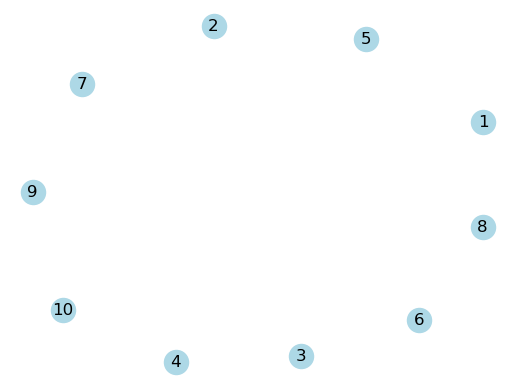

In [24]:
# Mostrar la salida
tsp_m.print_output()

### Resultados y analisis

### Visualizacion